In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_arz
from settings_file import *

import ipdb

# ARZ model simulation

In [2]:

env = gym.make("arz-v0", sett=settings, cont_sett = control_settings)

print("Action space is discrete?:", env.discrete)
print("Size of actions: {}".format(env.action_space))


Case 1: Outlet Boundary Control
Determinstic Env.
Initial condition of rs: 0.12
Action space is discrete?: False
Size of actions: Box(1,)


/home/saehong/miniconda3/envs/shp_1/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
r_size = len(env.r)
y_size = len(env.y)
v_size = len(env.v)

In [8]:
## Parameter values from the Gym environment

# Parameter
vm = settings['vm']#40
rm = settings['rm']#0.16
tau = settings['tau']#60
L = settings['L']#500
T = settings['T'] * 4 #settings['T'] is 120 (2mins)
vs = settings['vs']#10
rs  = settings['rs']#0.12
qs  = settings['qs']#rs * vs
gam = settings['gam']#1
ps  = vm/rm * qs/vs
ys  = 0;


# Discretization
dx = settings['dx']#5
dt = settings['dt']#0.1
t = np.arange(0,T+dt,dt)
x = np.arange(0,L+dx,dx)
M = len(x)
N = len(np.arange(0,T+dt,dt))

# charateristics
lambda_1 = vs ;
lambda_2 = vs - rs * vm/rm ;

# Fundamental diagram
Veq = lambda rho: vm * ( 1 - rho/rm)

# Flux
F_r = lambda rho,y: y + rho * Veq(rho)
F_y = lambda rho,y: y * (y/rho + Veq(rho))

# Spatial function
c_x = lambda x: -1 / tau * np.exp(-x/tau/vs)


In [ ]:
# Simulation setting

r_save_base = np.zeros([r_size,N])
y_save_base = np.zeros([y_size,N])
v_save_base = np.zeros([v_size,N])
action_save_base = np.zeros([2,N])
reward_save_base = np.zeros(N)

env.reset()
r_save_base[:,0] = env.r.reshape(r_size,)
y_save_base[:,0] = env.y.reshape(y_size,)
v_save_base[:,0] = env.v.reshape(v_size,)
action_save_base[:,0] = 0



rs = env.rs#0.12
vs = env.vs#10
qs = env.qs

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Find input index close to qs_input
env_qs_input = env.qs_input
idx = find_nearest(env_qs_input,qs)

DISCRETE = env.discrete

for i in range(N-1):
    #action = find_nearest(env_qs_input,qs)
    if DISCRETE:
        action = find_nearest(env_qs_input,qs)
    else:
        action = np.array([qs,qs])
    states, reward, is_done, info = env.step(action)
    r_save_base[:,i+1] = env.r.reshape(r_size,)
    y_save_base[:,i+1] = env.y.reshape(y_size,)
    v_save_base[:,i+1] = env.v.reshape(v_size,)
    action_save_base[:,i+1] = action
    reward_save_base[i+1] = reward

# Visualization

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# ax.plot3D(xline, yline, zline, 'gray')

## create meshgrid
L = settings['L']  #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T+dt,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Density [veh/km]')
ax.set_title(r'$\rho$')
ax.plot_surface(xx[0:,0:],tt[0:,0:],r_save_base[0:,0:],cmap=plt.cm.gray,edgecolors='#000000',linewidth=1,antialiased=True,rstride=1,cstride=100)
ax.plot(xx[:,0],tt[:,0],r_save_base[:,0],color='blue',LineWidth=4)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

## create meshgrid
L = settings['L'] #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T+dt,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Velocity [m/s]')
ax.set_title(r'$V$')
ax.plot_surface(xx[0:,0:],tt[0:,0:],v_save_base[0:,0:],cmap=plt.cm.gray,edgecolors='#000000',linewidth=0.5,antialiased=True,rstride=1,cstride=100)
ax.plot(xx[:,0],tt[:,0],v_save_base[:,0],color='blue',LineWidth=4)


# ax.plot_surface(xx,tt,v_save)

When we save the results in mat.file and plot them, they are looking better.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax1 = plt.subplots(figsize=(8,4))
plt.plot(t[1:],reward_save_base[1:])
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Reward')
plt.grid(True)
plt.show()


In [ ]:
sum(reward_save_base)

In [ ]:
q_save_base = r_save_base * v_save_base

In [ ]:
q_save_base.shape

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
plt.plot(t[1:],q_save_base[-2,1:])
plt.ylabel('q(L-1,t)')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
plt.plot(q_save_base[-1,1:])
plt.ylabel('q(L,t), applied input')
plt.xlabel('Time [sec]')

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))

plt.plot(q_save_base[0,:])
plt.ylabel('q(0,t)')
plt.xlabel('Time [sec]')

# I/O

Convert python data into Matlab data.

In [ ]:
import scipy.io as sio
sio.savemat('ARZ_python_result_Base_Stochastic_rs012.mat',{'r_vec_base':r_save_base, 'v_vec_base':v_save_base, 'rwd_base' : reward_save_base, 'input_base': action_save_base, 'xx': xx, 'tt' : tt})

# PDE controller

In [ ]:
# Interacting with env.

env.reset()
q_inlet_save = np.zeros([1,N])
r_save = np.zeros([r_size,N])
y_save = np.zeros([y_size,N])
v_save = np.zeros([v_size,N])
PDE_input_save = np.zeros([1,N])
reward_save = np.zeros(N)

r_save[:,0] = env.r.reshape(r_size,)
y_save[:,0] = env.y.reshape(y_size,)
v_save[:,0] = env.v.reshape(v_size,)

v_temp = y_save[:,0]/r_save[:,0] + Veq(r_save[:,0]) - vs * np.ones((M,))
v_temp = v_temp.reshape(v_temp.shape[0],1) # flatten -> column vector
q_temp = y_save[:,0] + r_save[:,0] * Veq(r_save[:,0]) - qs * np.ones((M,))
q_temp = q_temp.reshape(q_temp.shape[0],1) # flatten -> column vector

Trans_K =  np.transpose(K[:,0]).reshape(1,K[:,0].shape[0])
IM = np.fliplr(-Trans_K) * np.transpose(v_temp)

IK_v_left = lambda_2 / lambda_1 * K[M-1,:] * np.exp(x/tau/vs)
IK_v_left = IK_v_left.reshape(1,IK_v_left.shape[0]) # flatten -> row vector
IK_v = IK_v_left * np.transpose(v_temp)
IK_q_left = (lambda_1 - lambda_2) / qs * K[M-1,:] * np.exp(x/tau/vs)
IK_q_left = IK_q_left.reshape(1,IK_q_left.shape[0]) # flatten -> row vector
IK_q = IK_q_left * np.transpose(q_temp)

U = np.zeros(N)
U[0] = np.trapz(IM,x=x) + np.trapz(IK_v,x=x) + np.trapz(IK_q,x=x)

qs_input = (U[0]+vs)*r_save[-1,0]



def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Find input index close to qs_input
env_qs_input = env.qs_input
idx = find_nearest(env_qs_input,qs_input)

for i in range(N-1):
    #action = find_nearest(env_qs_input,qs_input)
    #q_inlet_save[:,i+1] = env.q_inlet.reshape(1,)
    if DISCRETE:
        action = find_nearest(env_qs_input,qs)
    else:
        action = qs_input
        PDE_input_save[:,i] = qs_input
    states, reward, is_done, info = env.step(action)
    r_save[:,i+1] = env.r.reshape(r_size,)
    y_save[:,i+1] = env.y.reshape(y_size,)
    v_save[:,i+1] = env.v.reshape(v_size,)
    reward_save[i+1] = reward
    
    # Closed-loop control
    v_temp = y_save[:,i+1]/r_save[:,i+1] + Veq(r_save[:,i+1]) - vs * np.ones((M,))
    v_temp = v_temp.reshape(v_temp.shape[0],1) # flatten -> column vector
    q_temp = y_save[:,i+1] + r_save[:,i+1] * Veq(r_save[:,i+1]) - qs * np.ones((M,))
    q_temp = q_temp.reshape(q_temp.shape[0],1) # flatten -> column vector

    Trans_K =  np.transpose(K[:,0]).reshape(1,K[:,0].shape[0])
    IM = np.fliplr(-Trans_K) * np.transpose(v_temp)

    IK_v_left = lambda_2 / lambda_1 * K[M-1,:] * np.exp(x/tau/vs)
    IK_v_left = IK_v_left.reshape(1,IK_v_left.shape[0]) # flatten -> row vector
    IK_v = IK_v_left * np.transpose(v_temp)
    IK_q_left = (lambda_1 - lambda_2) / qs * K[M-1,:] * np.exp(x/tau/vs)
    IK_q_left = IK_q_left.reshape(1,IK_q_left.shape[0]) # flatten -> row vector
    IK_q = IK_q_left * np.transpose(q_temp)

    U[i+1] = np.trapz(IM,x=x) + np.trapz(IK_v,x=x) + np.trapz(IK_q,x=x)

    qs_input = (U[i+1]+vs)*r_save[-1,i+1]



In [ ]:
r_save_bcmk = r_save
y_save_bcmk = y_save
v_save_bcmk = v_save
reward_save_bcmk = reward_save

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

## create meshgrid
L = settings['L']  #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T+dt,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Density [veh/km]')
ax.set_title(r'$\rho$')
ax.plot_surface(xx[0:,0:],tt[0:,0:],r_save_bcmk[0:,0:],cmap=plt.cm.gray,edgecolors='#000000',linewidth=1,antialiased=True,rstride=1,cstride=100)
ax.plot(xx[:,0],tt[:,0],r_save_bcmk[:,0],color='blue',LineWidth=4)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

## create meshgrid
L = settings['L'] #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T+dt,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Velocity [m/s]')
ax.set_title(r'$V$')
ax.plot_surface(xx[0:,0:],tt[0:,0:],v_save_bcmk[0:,0:],cmap=plt.cm.gray,edgecolors='#000000',linewidth=1,antialiased=True,rstride=1,cstride=100)
ax.plot(xx[:,0],tt[:,0],v_save_bcmk[:,0],color='blue',LineWidth=4)



In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax1 = plt.subplots(figsize=(8,4))


plt.plot(t,reward_save)
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Reward')
plt.grid(True)
plt.show()


In [ ]:
sum(reward_save_bcmk)

We plot the input profile here

In [ ]:
q_save_bcmk = r_save_bcmk * v_save_bcmk

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_inlet_save[0,1:])
plt.ylabel('q(L,t)')
plt.xlabel('Time [sec]')

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_save_bcmk[-1,:])
plt.ylabel('q(L,t)')
plt.xlabel('Time [sec]')

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_save_bcmk[0,:])
plt.ylabel('q(0,t)')
plt.xlabel('Time [sec]')

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(PDE_input_save[0,:-1])
plt.xlabel('Time [sec]')
plt.ylabel('q(L,t)')
plt.title('INPUT SHAPE')
plt.grid(True)
plt.show()

Save data for PLOT.

In [ ]:
import scipy.io as sio
sio.savemat('ARZ_python_result_BCMK.mat',{'r_vec_bcmk':r_save_bcmk, 'v_vec_bcmk':v_save_bcmk, 'rwd_bcmk' : reward_save_bcmk, 'input_bcmk': PDE_input_save,'xx': xx, 'tt' : tt})

# PPO Controller

Paste from enjoy.py. file

This is different from above as the environemnt is VECTORIZED.. So you may need to restart if you want to simulate above code again.


In [3]:
import argparse
import os
# workaround to unpickle olf model files
import sys

import numpy as np
import torch

from a2c_ppo_acktr.envs import VecPyTorch, make_vec_envs, make_vec_envs_arz
from a2c_ppo_acktr.utils import get_render_func, get_vec_normalize

import ipdb #SHP 
import gym_arz #SHP
from settings_file import *

In [4]:
from types import SimpleNamespace
# args = SimpleNamespace(env_name="arz-v0", load_dir="./trained_models/ppo", seed = 1, det = True, non_det = False, log_interval=10)

## 1.Control Outlet, fix inlet
args = SimpleNamespace(env_name="arz-v0", load_dir="save_results/1_Outlet_Boundary_Results", seed = 1, det = True, non_det = False, log_interval=10)

## 2.Control inlet, fix outlet 
# args = SimpleNamespace(env_name="arz-v0", load_dir="./0914_inlet_controls/2020-09-14-15-52", seed = 1, det = True, non_det = False, log_interval=10)

## 3.Control inlet & outlet 
# args = SimpleNamespace(env_name="arz-v0", load_dir="./0915_inlet_outlet_controls/2020-09-16-10-33", seed = 1, det = True, non_det = False, log_interval=10)

## 4.Control inlet & outlet w/ random r_s
# args = SimpleNamespace(env_name="arz-v0", load_dir="./0917_inlet_outlet_controls_random/2020-09-17-12-06", seed = 1, det = True, non_det = False, log_interval=10)


# args.env_name = "arz-v0"
# args.load_dir = "./trained_models/ppo"

In [5]:
env_vec = make_vec_envs_arz(
    args.env_name,
    settings,
    control_settings,
    args.seed + 1000,
    1,
    None,
    None,
    device='cpu',
    allow_early_resets=False)


# Get a render function
render_func = get_render_func(env_vec)

# We need to use the same statistics for normalization as used in training


## 1.Control Outlet, fix inlet
actor_critic, ob_rms = \
            torch.load(os.path.join(args.load_dir, args.env_name + "-tr-920-th" + ".pt"),map_location='cpu')

## 2.Control inlet, fix outlet controller
# actor_critic, ob_rms = \
#             torch.load(os.path.join(args.load_dir, args.env_name + "-tr-2080-th" + ".pt"),map_location='cpu')

## 3.Control inlet & outlet 
# actor_critic, ob_rms = \
#             torch.load(os.path.join(args.load_dir, args.env_name + "-tr-2080-th" + ".pt"),map_location='cpu')

## 4.Control inlet & outlet w/ random r_s
# actor_critic, ob_rms = \
#             torch.load(os.path.join(args.load_dir, args.env_name + "-tr-2080-th" + ".pt"),map_location='cpu')


vec_norm = get_vec_normalize(env_vec)
if vec_norm is not None:
    vec_norm.eval()
    vec_norm.ob_rms = ob_rms

recurrent_hidden_states = torch.zeros(1,
                                      actor_critic.recurrent_hidden_state_size)
masks = torch.zeros(1, 1)

obs = env_vec.reset()


Case 1: Outlet Boundary Control
Determinstic Env.
Initial condition of rs: 0.12
Case 1: Outlet Boundary Control
Determinstic Env.
Initial condition of rs: 0.12


/home/saehong/miniconda3/envs/shp_1/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [35]:
args.det = True

## Added by SHP
obs_save = []
rwd_save = []
PPO_input_save = []
PPO_RHO_SAVE = []
PPO_VEL_SAVE = []

TIME_VEC = []
dt = settings['dt']

# Intial Condtions
obs = env_vec.reset()
obs_save.append(obs)

PPO_RHO_SAVE.append((obs[0][0:51]*env.rs_desired+env.rs_desired).tolist())
PPO_VEL_SAVE.append((obs[0][51:]*env.vs_desired+env.vs_desired).tolist())


ACTION_VEC = []
ACTION_VEC.append(np.array([0,0]))


tt = 0
TIME_VEC.append(tt)




# while True:
for i in range(N-1):
    with torch.no_grad():
        value, action, _, recurrent_hidden_states = actor_critic.act(
            obs, recurrent_hidden_states, masks, deterministic=args.det)
        
    action = action[0]

    PPO_input_save.append(action)
    
    obs, reward, done, _ = env_vec.step(action)
    
    
    if done:
        print('DONE')
        break
    
    ## Append Observation & Reward
    obs_save.append(obs) 
    rwd_save.append(reward) 
              
    ## Vectorized version
    PPO_RHO_SAVE.append((obs[0][0:51]*env.rs_desired+env.rs_desired).tolist())
    PPO_VEL_SAVE.append((obs[0][51:]*env.vs_desired+env.vs_desired).tolist())
    
    ## Append Action
    ACTION_VEC.append(action.detach().numpy())



        
    ## 
    tt += dt
    TIME_VEC.append(tt)
    
    
    

    


Case 1: Outlet Boundary Control
Determinstic Env.
Initial condition of rs: 0.12
Time over..
Case 1: Outlet Boundary Control
Determinstic Env.
Initial condition of rs: 0.12
DONE


In [36]:

r_save_RL = np.array(PPO_RHO_SAVE)
r_save_RL = r_save_RL.T

v_save_RL = np.array(PPO_VEL_SAVE)
v_save_RL = v_save_RL.T

action_save_RL = np.array(ACTION_VEC)
reward_save_RL = rwd_save

<IPython.core.display.Javascript object>


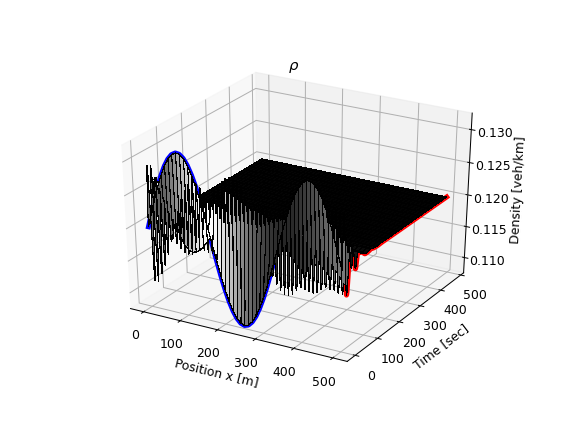

In [88]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


## create meshgrid
L = settings['L']  #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Time [sec]')
ax.set_zlabel('Density [veh/km]')
ax.set_title(r'$\rho$')
ax.plot_surface(xx[0:,0:],tt[0:,0:],r_save_RL[0:,0:],cmap=plt.cm.gray,edgecolors='#000000',linewidth=0.1,antialiased=False,rstride=1,cstride=100)
ax.plot(xx[:,0],tt[:,0],r_save_RL[:,0],color='blue',LineWidth=4)
ax.plot(xx[-1,:],tt[-1,:],r_save_RL[-1,:],color='red',LineWidth=4)


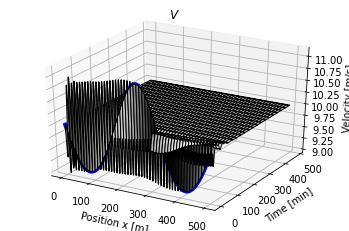

In [55]:
from mpl_toolkits.mplot3d import Axes3D

## create meshgrid
L = settings['L'] #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Time [min]')
ax.set_zlabel('Velocity [m/s]')
ax.set_title(r'$V$')
ax.plot_surface(xx[0:,0:],tt[0:,0:],v_save_RL[0:,0:],cmap=plt.cm.gray,edgecolors='#000000',linewidth=1,antialiased=True,rstride=1,cstride=100)
ax.plot(xx[:,0],tt[:,0],v_save_RL[:,0],color='blue',LineWidth=4)


### PPO REWARD PLOT

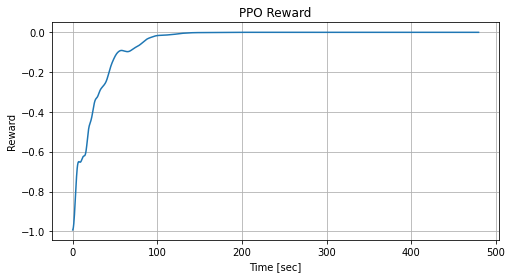

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax1 = plt.subplots(figsize=(8,4))

rwd_save_PPO = np.array(reward_save_RL)

plt.plot(TIME_VEC[:-1],reward_save_RL)
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('PPO Reward')
plt.grid(True)
plt.show()

In [57]:
sum(rwd_save_PPO)

-105.22413613367826

In [58]:
q_save_RL = r_save_RL * v_save_RL

Text(0.5, 0, 'Time [sec]')

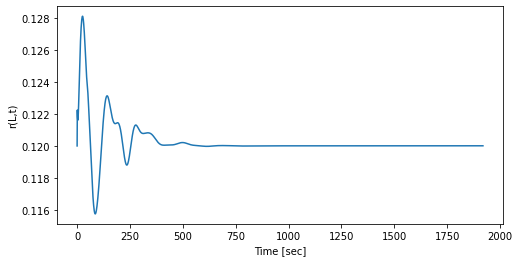

In [59]:
fig, ax1 = plt.subplots(figsize=(8,4))

plt.plot(r_save_RL[-1,:])
plt.ylabel('r(L,t)')
plt.xlabel('Time [sec]')

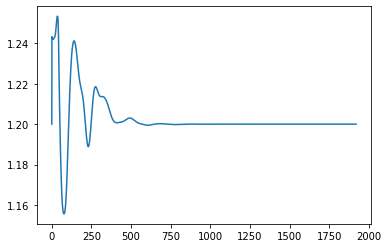

In [60]:
plt.plot(r_save_RL[-1,:]*v_save_RL[-1,:])
plt.show()

Text(0.5, 0, 'Time [sec]')

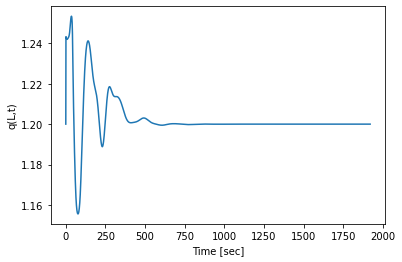

In [61]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_save_RL[-1,:])
plt.ylabel('q(L,t)')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

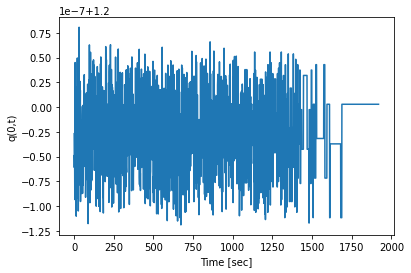

In [62]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_save_RL[0,:])
plt.ylabel('q(0,t)')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

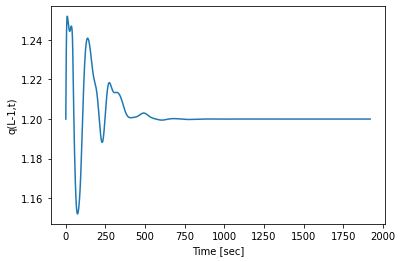

In [63]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_save_RL[-2,:])
plt.ylabel('q(L-1,t)')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

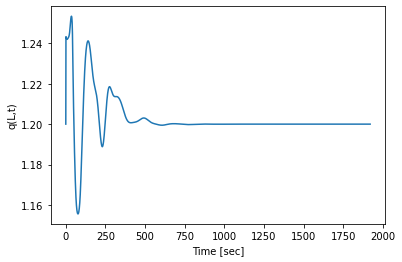

In [64]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(q_save_RL[-1,:])
plt.ylabel('q(L,t)')
plt.xlabel('Time [sec]')

In [65]:
action_save_RL[1]

array([1.2432909], dtype=float32)

In [66]:
action_save_RL.shape

(1920,)

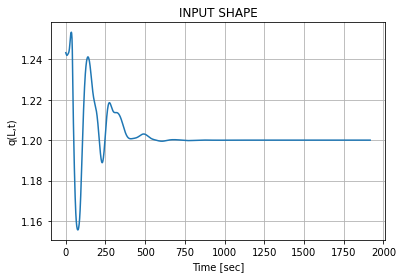

In [68]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(action_save_RL[1:-1,1])
plt.xlabel('Time [sec]')
plt.ylabel('q(L,t)')
plt.title('INPUT SHAPE')
plt.grid(True)
plt.show()

IndexError: too many indices for array

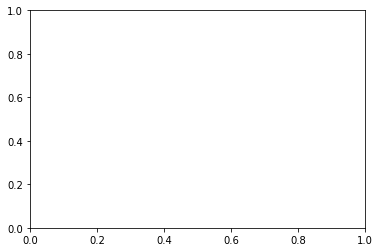

In [69]:
fig, ax1 = plt.subplots(figsize=(6,4))

plt.plot(action_save_RL[1:-1,0])
plt.xlabel('Time [sec]')
plt.ylabel('q(0,t)')
plt.title('INPUT SHAPE')
plt.grid(True)
plt.show()

In [ ]:
import scipy.io as sio
sio.savemat('ARZ_python_result_RL_Stochastic_rs0115_480.mat',{'r_vec_RL':r_save_RL, 'v_vec_RL':v_save_RL, 'rwd_RL' : reward_save_RL, 'input_RL': action_save_RL, 'xx': xx, 'tt' : tt})

//////////////////////////////////
여기까지 진행함. 2020.05.18
/////////////////////////////////

## Use 'PPO_input' to environment

In [ ]:
env.reset()
obs_save = []
rwd_save = []


for i in range(len(PPO_input_save)):
    obs, reward, done, _ = env.step(PPO_input_save[i][0][0].numpy())
    obs_save.append(obs)
    rwd_save.append(reward)
    
    
plt.plot(rwd_save)
plt.show()    

### PDE BackStepping REWARD PLOT

In [ ]:
plt.plot(t,reward_save,label='Benchmark')
plt.plot(t[:-1],rwd_save, label='PPO')
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Reward Comparison')
plt.grid(True)
plt.legend()
plt.show()

### PPO INPUT PLOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.plot(t[:-1],PPO_input_save)
plt.xlabel('Time [sec]')
plt.ylabel('qs_input')
plt.title('PPO INPUT')
plt.grid(True)
plt.show()

### PDE BackStepping INPUT PLOT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.plot(t[:-1],PDE_input_save[0,:-1])
plt.xlabel('Time [sec]')
plt.ylabel('qs_input')
plt.title('Benchmark INPUT')
plt.grid(True)
plt.show()

See how state looks like over time horizon

In [ ]:
# Extracting r_save, v_save for plot
PPO_r_save_plt = np.zeros([51,len(PPO_r_save)])
PPO_v_save_plt = np.zeros([51,len(PPO_v_save)])


for i in range(len(PPO_r_save)):
    PPO_r_save_plt[:,i] = PPO_r_save[i].numpy().reshape([51,])*rs + rs
    PPO_v_save_plt[:,i] = PPO_v_save[i].numpy().reshape([51,])*vs + vs


In [ ]:
plt.plot(PPO_r_save_plt[:,0])
# plt.plot(r_save[:,0])
plt.xlabel('X')
plt.ylabel('r')
plt.grid(True)
plt.show()


# plt.plot(PPO_r_save_plt[:,0])
plt.plot(r_save[:,0])
plt.xlabel('X')
plt.ylabel('r')
plt.grid(True)
plt.show()

### 3D Plot


In [ ]:
from mpl_toolkits.mplot3d import Axes3D


## create meshgrid
L = settings['L']  #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T+dt,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,tt,PPO_r_save_plt*1000)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D


## create meshgrid
L = settings['L']  #[m]
dx = settings['dx']
x = np.arange(0,L+dx,dx)
t = np.arange(0,T+dt,dt)

xx, tt = np.meshgrid(x,t,indexing='ij')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,tt,PPO_v_save_plt)

In [ ]:
# import scipy.io as sio
# sio.savemat('ARZ_python_result_PPOsave.mat',{'r_vec_PPO':PPO_r_save_plt, 'v_vec_PPO':PPO_v_save_plt, 'rwd_PPO' : rwd_save, 'xx': xx, 'tt' : tt})

# Below is not used..

#### 1. Smooth rewards

In [ ]:
import pandas as pd

# parameters
smoothing_window = 10

# Smooth
rewards_smth = pd.Series(rwd_save).rolling(smoothing_window, min_periods=smoothing_window).mean()

# Plot
plt.plot(t[:-1],rewards_smth)
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Smoothed Reward')
plt.grid(True)
plt.show()


In [ ]:
sum(rewards_smth[9:])


#### 2.Smooth actions and use them to environment

In [ ]:
r_save = np.zeros([r_size,N])
y_save = np.zeros([y_size,N])
v_save = np.zeros([v_size,N])
action_save = np.zeros([env.action_space.shape[0],N-1])
reward_save = np.zeros(N)

states = env.reset()
r_save[:,0] = env.r.reshape(r_size,)
y_save[:,0] = env.y.reshape(y_size,)
v_save[:,0] = env.v.reshape(v_size,)



for i in range(N-1):
    action = agent.compute_action(states)
    states, reward, is_done, info = env.step(action)
    r_save[:,i+1] = env.r.reshape(r_size,)
    y_save[:,i+1] = env.y.reshape(y_size,)
    v_save[:,i+1] = env.v.reshape(v_size,)
    reward_save[i+1] = reward
    action_save[:,i] = action



In [ ]:
# Smooth the action and replay.

# parameters
smoothing_window = 10

# Smooth
action_smth = pd.Series(PPO_input_save).rolling(smoothing_window, min_periods=smoothing_window).mean()

for i in range(smoothing_window):
    action_smth[i]=action_smth[smoothing_window]

# Plot
plt.plot(t[:-1], action_smth)
plt.xlabel('Time [sec]')
plt.ylabel('Action_idx')
plt.title('Smooth Action')
plt.grid(True)
plt.show()
    

In [ ]:
action_smth[i]

In [ ]:
obs = env.reset()

## Added by SHP
obs_smth_save = []
rwd_smth_save = []
PPO_input_save = []
# ipdb.set_trace()
obs_save.append(obs)


if args.env_name.find('Bullet') > -1:
    import pybullet as p

    torsoId = -1
    for i in range(p.getNumBodies()):
        if (p.getBodyInfo(i)[0].decode() == "torso"):
            torsoId = i

for i in range(len(action_smth)):

    # Obser reward and next obs
    obs, reward, done, _ = env.step(action_smth[i])
    obs_smth_save.append(obs) # SHP
    rwd_smth_save.append(reward) # SHP

    masks.fill_(0.0 if done else 1.0)

    if args.env_name.find('Bullet') > -1:
        if torsoId > -1:
            distance = 5
            yaw = 0
            humanPos, humanOrn = p.getBasePositionAndOrientation(torsoId)
            p.resetDebugVisualizerCamera(distance, yaw, -20, humanPos)

    if done:
        break
    ## Commented by SHP.

## RL-Lib version [NOT USED HERE]

In [ ]:
shp=agent.get_policy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.plot(t,reward_save)
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Reward')
plt.grid(True)
plt.show()


In [ ]:
sum(reward_save)

In [ ]:
import scipy.io as sio
xx, tt = np.meshgrid(x,t,indexing='ij')
sio.savemat('ARZ_python_result_RL.mat',{'r_vec_RL':r_save, 'v_vec_RL':v_save, 'rwd_RL' : reward_save, 'xx': xx, 'tt' : tt})

### Smooth

2019.01.31 
- 1) Using Pandas, smooth the curve and re-use the input see resutls.
- 2) Moving average method, see the curve

#### 1. Smooth rewards

In [ ]:
import pandas as pd

# parameters
smoothing_window = 10

# Smooth
rewards_smth = pd.Series(reward_save).rolling(smoothing_window, min_periods=smoothing_window).mean()

# Plot
plt.plot(t,rewards_smth)
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Smoothed Reward')
plt.grid(True)
plt.show()


#### 2.Smooth actions and use them to environment

In [ ]:
r_save = np.zeros([r_size,N])
y_save = np.zeros([y_size,N])
v_save = np.zeros([v_size,N])
action_save = np.zeros([env.action_space.shape[0],N-1])
reward_save = np.zeros(N)

states = env.reset()
r_save[:,0] = env.r.reshape(r_size,)
y_save[:,0] = env.y.reshape(y_size,)
v_save[:,0] = env.v.reshape(v_size,)



for i in range(N-1):
    action = agent.compute_action(states)
    states, reward, is_done, info = env.step(action)
    r_save[:,i+1] = env.r.reshape(r_size,)
    y_save[:,i+1] = env.y.reshape(y_size,)
    v_save[:,i+1] = env.v.reshape(v_size,)
    reward_save[i+1] = reward
    action_save[:,i] = action



In [ ]:
# Plot the action
action_save_1d = action_save.flatten('C') 
plt.plot(t[:-1], action_save_1d)
plt.xlabel('Time [sec]')
plt.ylabel('Action_idx')
plt.title('Action')
plt.grid(True)
plt.show()


In [ ]:
# Smooth the action and replay.

# parameters
smoothing_window = 10

# Smooth
action_smth = pd.Series(action_save_1d).rolling(smoothing_window, min_periods=smoothing_window).mean()

for i in range(smoothing_window):
    action_smth[i]=action_smth[smoothing_window]

# Plot
plt.plot(t[:-1], action_smth)
plt.xlabel('Time [sec]')
plt.ylabel('Action_idx')
plt.title('Smooth Action')
plt.grid(True)
plt.show()
    

In [ ]:
# Re-run

r_save = np.zeros([r_size,N])
y_save = np.zeros([y_size,N])
v_save = np.zeros([v_size,N])
reward_save = np.zeros(N)

states = env.reset()
r_save[:,0] = env.r.reshape(r_size,)
y_save[:,0] = env.y.reshape(y_size,)
v_save[:,0] = env.v.reshape(v_size,)

for i in range(N-1):
    action = action_smth[i]
    states, reward, is_done, info = env.step(action)
    r_save[:,i+1] = env.r.reshape(r_size,)
    y_save[:,i+1] = env.y.reshape(y_size,)
    v_save[:,i+1] = env.v.reshape(v_size,)
    reward_save[i+1] = reward
    action_save[:,i] = action

# Plot
plt.plot(t,reward_save)
plt.xlabel('Time [sec]')
plt.ylabel('Reward')
plt.title('Reward')
plt.grid(True)
plt.show() 


In [ ]:
# Save
import scipy.io as sio
xx, tt = np.meshgrid(x,t,indexing='ij')
sio.savemat('ARZ_python_result_RL_smth_rand_tau.mat',{'r_vec_RL':r_save, 'v_vec_RL':v_save, 'rwd_RL' : reward_save, 'xx': xx, 'tt' : tt})